In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from dateutil.parser import parse
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt

In [2]:
###TODO: remove outliers, expand to full data, fix the size error idk why thats happening

In [3]:


df = pd.read_csv('F1_4502\LapAndWeather\LapWeather_Australian Grand Prix')
df = df.drop(['Time','DriverNumber', 'Unnamed: 0', 'LapNumber', 'PitOutTime', 'PitInTime', 'Sector1Time','Sector2Time','Sector3Time','Sector1SessionTime','Sector2SessionTime','Sector3SessionTime','SpeedI1','SpeedI2','SpeedST','IsPersonalBest','FreshTyre','Stint','SpeedFL','LapStartTime','Team','Driver','TrackStatus','IsAccurate'], axis=1)
df = df.dropna()

dfOutput = df['LapTime']
dfInput = df.drop(['LapTime'], axis=1)
dfInput = dfInput.replace({'ULTRASOFT': 0, 'SUPERSOFT': 1, 'SOFT': 2,})
train_inputs = dfInput.to_numpy()
train_targets = dfOutput.to_numpy()
for i in range(len(train_targets)):
    train_targets[i] = train_targets[i].replace('0 days ', '')
actual_train_targets = []
for time in train_targets:
    td = parse(time) - parse('00:00:00')
    seconds = td.total_seconds()
    actual_train_targets.append(seconds)
inputs_array = train_inputs.astype('float64')
targets_array = np.array(actual_train_targets)
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)


In [4]:
dataset = TensorDataset(inputs, targets)


In [5]:
val_percent = 0.2
num_rows = len(dfInput.index)
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [6]:
batch_size = 9
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_ds, batch_size, num_workers = 0)

In [7]:
input_size = len(inputs[0])
output_size = 1

In [8]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(9, 36),
            nn.ReLU(),
            nn.Linear(36,18),
            nn.ReLU(),
            nn.Linear(18,1)
        )
        
    def forward(self, xb):
        out = self.layers(xb)                       
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')  
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [9]:
model = LinearRegressionModel()


In [10]:
list(model.parameters())

[Parameter containing:
 tensor([[ 2.6978e-01,  1.4664e-01, -9.8114e-02, -2.3224e-01,  9.9271e-02,
          -1.8257e-02, -1.9397e-01, -2.4023e-01, -2.0853e-02],
         [ 2.0967e-02,  2.5637e-01,  1.1477e-01,  1.3259e-01, -4.9295e-02,
          -1.7751e-01,  1.3954e-01,  8.1807e-02, -1.6559e-01],
         [-2.7741e-01, -4.2840e-02,  7.6567e-03,  1.0796e-01, -2.9731e-01,
           2.0416e-01,  2.2638e-01, -1.2775e-01,  1.7533e-01],
         [ 6.2311e-02, -3.9637e-02, -1.3734e-01,  1.8972e-01, -3.7335e-02,
           1.3090e-01,  1.5170e-01,  7.9975e-02,  3.0079e-01],
         [-1.4685e-01, -1.0247e-01,  3.2255e-02,  2.4268e-01,  1.5908e-01,
          -2.3604e-01, -2.4843e-01,  1.5151e-01, -2.8983e-01],
         [-1.1720e-02, -3.1662e-02,  3.9582e-02, -2.9857e-01, -2.4464e-01,
           2.6485e-01, -1.5327e-01, -2.3753e-01, -1.8167e-01],
         [ 1.7362e-01,  1.5587e-01,  3.1350e-01, -8.3449e-02,  2.8579e-02,
           2.4136e-01, -3.5320e-02,  1.4266e-01, -2.7062e-01],
         [ 

In [11]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [12]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 137.30996704101562}


<ipython-input-8-53c0ad504869>:29: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')
<ipython-input-8-53c0ad504869>:29: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')


In [13]:
epochs = 1000
lr = 1e-7
history1 = fit(epochs, lr, model, train_loader, val_loader)

<ipython-input-8-53c0ad504869>:21: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')
<ipython-input-8-53c0ad504869>:21: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')
<ipython-input-8-53c0ad504869>:29: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(input = out, target = target

Epoch [20], val_loss: 109.2818
Epoch [40], val_loss: 89.1054
Epoch [60], val_loss: 69.4889
Epoch [80], val_loss: 47.2336
Epoch [100], val_loss: 20.4574
Epoch [120], val_loss: 5.2669
Epoch [140], val_loss: 5.2575
Epoch [160], val_loss: 5.2575
Epoch [180], val_loss: 5.2577
Epoch [200], val_loss: 5.2568
Epoch [220], val_loss: 5.2552
Epoch [240], val_loss: 5.2548
Epoch [260], val_loss: 5.2566
Epoch [280], val_loss: 5.2554
Epoch [300], val_loss: 5.2543
Epoch [320], val_loss: 5.2532
Epoch [340], val_loss: 5.2518
Epoch [360], val_loss: 5.2528
Epoch [380], val_loss: 5.2512
Epoch [400], val_loss: 5.2510
Epoch [420], val_loss: 5.2496
Epoch [440], val_loss: 5.2510
Epoch [460], val_loss: 5.2487
Epoch [480], val_loss: 5.2474
Epoch [500], val_loss: 5.2475
Epoch [520], val_loss: 5.2478
Epoch [540], val_loss: 5.2426
Epoch [560], val_loss: 5.2403
Epoch [580], val_loss: 5.2372
Epoch [600], val_loss: 5.2375
Epoch [620], val_loss: 5.2351
Epoch [640], val_loss: 5.2337
Epoch [660], val_loss: 5.2351
Epoch [6

In [14]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                
    prediction = predictions[0].detach()
    return target, prediction

In [15]:
input, target = val_ds[11]
predict_single(input, target, model)

(tensor(89.2850), tensor([89.5403]))

In [16]:
input, target = val_ds[50]
predict_single(input, target, model)

(tensor(125.4380), tensor([89.7986]))

In [17]:
targets = []
predictions = []
for i in range(len(val_ds)):
    input, target = val_ds[i]
    target, prediction = predict_single(input, target, model)
    targets.append(target)
    predictions.append(prediction)


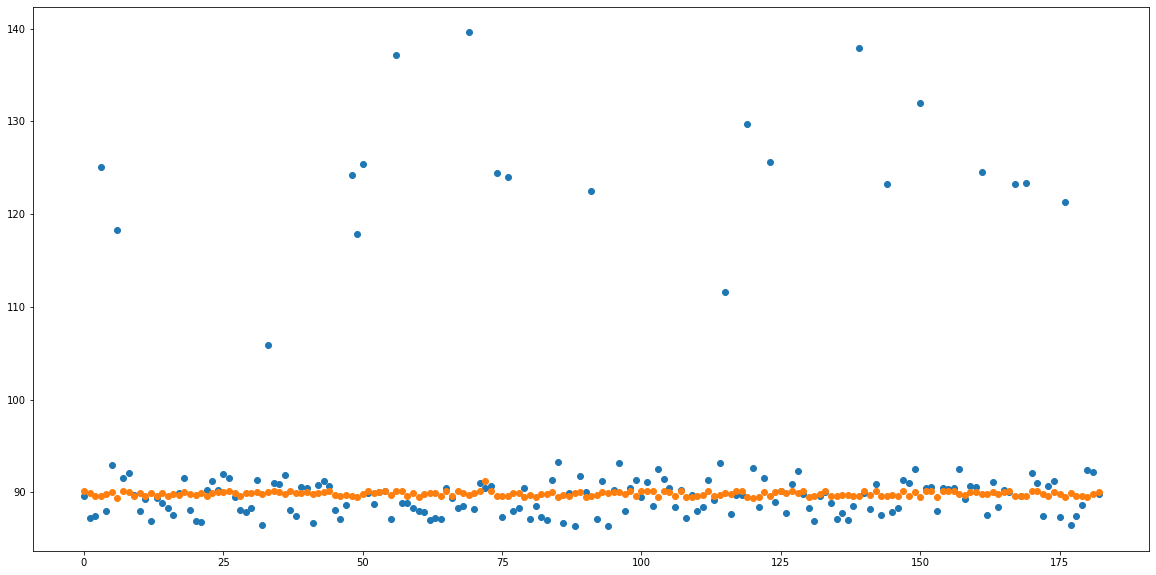

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(range(len(predictions)),targets)
ax.scatter(range(len(predictions)), predictions)
